<a href="https://colab.research.google.com/github/RohanSubramani/Miscellaneous/blob/main/Rohan_Transformer_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the notebook I (Rohan Subramani) used to follow along with Neel Nanda's [video tutorial on implementing GPT-2](https://neelnanda.io/transformer-tutorial-2). I wrote ~all of the code that comes after the "Actual Code!" heading, albeit while regularly referencing the video and the [solution notebook](https:https://www.neelnanda.io/transformer-solution//). I made sure to understand what each line was doing before writing it in cases where I wasn't able to come up with it myself. I may try repeating this exercise with many fewer peeks at the solution soon.

In [ ]:
!nvidia-smi

Wed Feb 22 03:54:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   3982MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction

(Most of the text here is from Neel Nanda.) This is a template for a clean, first principles implementation of GPT-2 in PyTorch. This is an accompaniment to [my video tutorial on implementing GPT-2](https://neelnanda.io/transformer-tutorial-2). If you want to properly understand how to implement GPT-2, you'll need to do it yourself! **I recommend filling out this template *as* you watch the video, and seeing how far you can get with each section before watching me do it**. Each section comes with tests, so you can check that you got it right. You can see [a solution notebook here](https://www.neelnanda.io/transformer-solution) - use it if you get stuck, but make an attempt first, and no copying and pasting!

There's a [template version of this notebook here](https://neelnanda.io/transformer-template), go and fill in the blanks (no copying and pasting!) and see if you can pass the tests. 

If you enjoyed this, I expect you'd enjoy learning more about what's actually going on inside these models and how to reverse engineer them! This is a fascinating young research field, with a lot of low-hanging fruit and open problems! **I recommend starting with my post [Concrete Steps for Getting Started in Mechanistic Interpretability](https://www.neelnanda.io/mechanistic-interpretability/getting-started).**

This notebook was written to accompany my [TransformerLens library](https://github.com/neelnanda-io/TransformerLens) for doing mechanistic interpretability research on GPT-2 style language models, and is a clean implementation of the underlying transformer architecture in the library. (This notebook is based off of an earlier version called EasyTransformer)

Further Resources:
* [A Comprehensive Mechanistic Interpretability Explainer & Glossary](https://www.neelnanda.io/glossary) 
    * Expecially [the transformers section](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=pndoEIqJ6GPvC1yENQkEfZYR)
* [200 Concrete Open Problems in Mechanistic Interpretability](https://www.neelnanda.io/concrete-open-problems)
* My [TransformerLens library](https://github.com/neelnanda-io/TransformerLens) for doing mechanistic interpretability research on GPT-2 style language models.
* My walkthrough of [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html), for a deeper dive into how to think about transformers:.

Check out these other intros to transformers for another perspective:
* Jay Alammar's [illustrated transformer](https://jalammar.github.io/illustrated-transformer/)
* [Andrej Karpathy's MinGPT](https://github.com/karpathy/minGPT)

**Sharing Guidelines:** This tutorial is still a bit of a work in progress! I think it's usable, but please don't post it anywhere publicly without checking with me first! Sharing with friends is fine. 

If you've found this useful, I'd love to hear about it! Positive and negative feedback also very welcome. You can reach me via [email](mailto:neelnanda27@gmail.com)

## Instructions
* No need to read the Setup Section
* Go to runtime > Change Runtime Type and set it to use a GPU
* Read and run notebook up until the start of the section "Actual Code!". Then go to the template notebook and try coding up the model yourself!
    * Bonus points for doing that without reading the solutions, and before I do it in the video!

# Setup

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  print("Running as a Colab notebook")
  %pip install git+https://github.com/neelnanda-io/Easy-Transformer.git@clean-transformer-demo
  # Install another version of node that makes PySvelte work way faster
  !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
  %pip install git+https://github.com/neelnanda-io/PySvelte.git
  %pip install fancy_einsum
  %pip install einops
except:
  IN_COLAB = False
  print("Running as a Jupyter notebook - intended for development only!")

In [ ]:
import einops
from fancy_einsum import einsum
from dataclasses import dataclass
from easy_transformer import EasyTransformer
import torch
import torch.nn as nn
import numpy as np
import math
from easy_transformer.utils import get_corner, gelu_new, tokenize_and_concatenate
import tqdm.auto as tqdm

In [ ]:
reference_gpt2 = EasyTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)

# Understanding Inputs & Outputs of a Transformer

## What is the point of a transformer?

**Transformers exist to model text!**

We're going to focus GPT-2 style transformers. Key feature: They generate text! You feed in language, and the model generates a probability distn over tokens. And you can repeatedly sample from this to generate text!

### How is the model trained?

You give it a bunch of text, and train it to predict the next token.

Importantly, if you give a model 100 tokens in a sequence, it predicts the next token for *each* prefix, ie it produces 100 predictions. This is kinda weird but it's much easier to make one that does this. And it also makes training more efficient, because you can 100 bits of feedback rather than just one.

#### Objection: Isn't this trivial for the first 99?

No! We make the transformer have *causal attention*. The core thing is that it can only move information forwards in the sequence. The prediction of what comes after token 50 is only a function of the first 50 tokens, *not* of token 51. (Jargon: *autoregressive*)

### Key takeaway:

Transformers are *sequence modelling engines*. It does the same processing in parallel at each sequence position, can move information between positions with attention, and conceptually can take a sequence of arbitrary length (not actually true, see later)

## Tokens - Transformer Inputs

Core point: Input is language (ie a sequence of characters, strings, etc)

### How do we convert language to vectors?

ML models take in vectors, not weird shit like language - how do we convert?

#### Idea: integers to vectors

We basically make a lookup table. Called an embedding. 

Jargon: **One-hot encoding** We map eg numbers from 1 to 100, to a 100-dim vector, with a 1 in the kth position, 0 everywhere else. Key intuition is that one-hot encodings let you think about each integer independently - useful when integers = labels. 

Dimensions = things that vary independently. Each input has its own dimension, so each input can be thought of independently, we don't bake in any relation.

Lookup tables <=> Multiply a fixed matrix by the one-hot encoded vector. 


### Tokens: Language to sequence of integers

Core idea: We need a model that can deal with arbitrary text. We want to convert this into integers, *and* we want these integers to be in a bounded range. 

**Idea:** Form a vocabulary!

**Idea 1:** Get a dictionary! 

**Problem:** It can't cope with arbitrary text (eg URLs, punctuation, etc) Can't cope with mispellings.

**Idea 2:** Vocab = 256 ASCII characters. Fixed vocab size, can do arbitrary text, etc.

**Problem:** Loses structure of language - some sequences of characters are more meaningful than others.

Eg "language" is a lot more meaningful than "hjksdfiu" - we want the first to be a single token, second to not be. It's a more efficient use of our vocab.

#### What Actually Happens?

This super cursed thing called Byte-Pair Encodings

Ġ ~ means begins with a space, tokens with a leading space vs not are different.

We begin with the 256 ASCII characters as our tokens, and then find the most common pair of tokens, and merge that into a new token. Eg " t" is the most common pair, so it's our next token! Repeat 50000 times...

In [ ]:
sorted_vocab = sorted(list(reference_gpt2.tokenizer.vocab.items()), key=lambda n:n[1])
print(sorted_vocab[:20])
print()
print(sorted_vocab[250:270])
print()
print(sorted_vocab[990:1010])
print()

[('!', 0), ('"', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ('(', 7), (')', 8), ('*', 9), ('+', 10), (',', 11), ('-', 12), ('.', 13), ('/', 14), ('0', 15), ('1', 16), ('2', 17), ('3', 18), ('4', 19)]

[('ľ', 250), ('Ŀ', 251), ('ŀ', 252), ('Ł', 253), ('ł', 254), ('Ń', 255), ('Ġt', 256), ('Ġa', 257), ('he', 258), ('in', 259), ('re', 260), ('on', 261), ('Ġthe', 262), ('er', 263), ('Ġs', 264), ('at', 265), ('Ġw', 266), ('Ġo', 267), ('en', 268), ('Ġc', 269)]

[('Ġprodu', 990), ('Ġstill', 991), ('led', 992), ('ah', 993), ('Ġhere', 994), ('Ġworld', 995), ('Ġthough', 996), ('Ġnum', 997), ('arch', 998), ('imes', 999), ('ale', 1000), ('ĠSe', 1001), ('ĠIf', 1002), ('//', 1003), ('ĠLe', 1004), ('Ġret', 1005), ('Ġref', 1006), ('Ġtrans', 1007), ('ner', 1008), ('ution', 1009)]



Gets to weird esoteric shit.

In [ ]:
sorted_vocab[-20:]

[('Revolution', 50237),
 ('Ġsnipers', 50238),
 ('Ġreverted', 50239),
 ('Ġconglomerate', 50240),
 ('Terry', 50241),
 ('794', 50242),
 ('Ġharsher', 50243),
 ('Ġdesolate', 50244),
 ('ĠHitman', 50245),
 ('Commission', 50246),
 ('Ġ(/', 50247),
 ('âĢ¦."', 50248),
 ('Compar', 50249),
 ('Ġamplification', 50250),
 ('ominated', 50251),
 ('Ġregress', 50252),
 ('ĠCollider', 50253),
 ('Ġinformants', 50254),
 ('Ġgazed', 50255),
 ('<|endoftext|>', 50256)]

Use the `to_tokens` method to convert text to numbers

Prepends with a special token to give attention a resting position, disable with `prepend_bos=False`

In [ ]:
print(reference_gpt2.to_tokens("Whether a word begins with a capital or space matters!"))
print(reference_gpt2.to_tokens("Whether a word begins with a capital or space matters!", prepend_bos=False))

tensor([[50256, 15354,   257,  1573,  6140,   351,   257,  3139,   393,  2272,
          6067,     0]])
tensor([[15354,   257,  1573,  6140,   351,   257,  3139,   393,  2272,  6067,
             0]])


### Rant: Tokenization is a Headache

Whether a word begins with a capital or space matters!

In [ ]:
print(reference_gpt2.to_str_tokens("Ralph"))
print(reference_gpt2.to_str_tokens(" Ralph"))
print(reference_gpt2.to_str_tokens(" ralph"))
print(reference_gpt2.to_str_tokens("ralph"))

['<|endoftext|>', 'R', 'alph']
['<|endoftext|>', ' Ralph']
['<|endoftext|>', ' r', 'alph']
['<|endoftext|>', 'ral', 'ph']


Arithmetic is a total mess: Length is inconsistent, common numbers bundle together

In [ ]:
reference_gpt2.to_str_tokens("56873+3184623=123456789-1000000000")

['<|endoftext|>',
 '568',
 '73',
 '+',
 '318',
 '46',
 '23',
 '=',
 '123',
 '45',
 '67',
 '89',
 '-',
 '1',
 '000000',
 '000']

### Key Takeaway:

* We learn a dictionary of vocab of tokens (sub-words).

* We (approx) losslessly convert language to integers via tokenizing it.

* We convert integers to vectors via a lookup table.

* Note: input to the transformer is a sequence of *tokens* (ie integers), not vectors

## Logits - Transformer Outputs

**Goal:** Probability distribution over next tokens. (for every *prefix* of the sequence - given n tokens, we make n next token predictions)

**Problem:** How to convert a vector to a probability distribution? 

**Answer:** Use a softmax ($x_i \to \frac{e^{x_i}}{\sum e^{x_j}}$), exponential makes everything positive, normalization makes it add to one.

So the model outputs a tensor of logits, one vector of size $d_{vocab}$ for each input token.

We can use this to generate things!

## Generation!

**Step 1:** Convert text to tokens

Shape = batch x position

In [ ]:
reference_text = "I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world!"
tokens = reference_gpt2.to_tokens(reference_text)
print(tokens)
print(tokens.shape)
print(reference_gpt2.to_str_tokens(tokens))

tensor([[50256,    40,   716,   281,  4998,  1960,   382, 19741,    11,   875,
         12342,    12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,
            13,  1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,
          1011,   625,   262,   995,     0]])
torch.Size([1, 35])
['<|endoftext|>', 'I', ' am', ' an', ' amazing', ' aut', 'ore', 'gressive', ',', ' dec', 'oder', '-', 'only', ',', ' G', 'PT', '-', '2', ' style', ' transformer', '.', ' One', ' day', ' I', ' will', ' exceed', ' human', ' level', ' intelligence', ' and', ' take', ' over', ' the', ' world', '!']


**Step 2:** Map tokens to logits

(run_with_cache means cache all intermediate activations, not important right now)

shape = batch x position x d_vocab

In [ ]:
tokens = tokens.cuda()
logits, cache = reference_gpt2.run_with_cache(tokens)
print(logits.shape)

torch.Size([1, 35, 50257])


**Step 3:** Convert the logits to a distribution with a softmax

In [ ]:
log_probs = logits.log_softmax(dim=-1)
probs = logits.log_softmax(dim=-1)
print(log_probs.shape)
print(probs.shape)

torch.Size([1, 35, 50257])
torch.Size([1, 35, 50257])


**Bonus step:** What is the most likely next token at each position?

In [ ]:
list(zip(reference_gpt2.to_str_tokens(reference_text), reference_gpt2.tokenizer.batch_decode(logits.argmax(dim=-1)[0])))

[('<|endoftext|>', '\n'),
 ('I', "'m"),
 (' am', ' a'),
 (' an', ' avid'),
 (' amazing', ' person'),
 (' aut', 'od'),
 ('ore', 'sp'),
 ('gressive', '.'),
 (',', ' and'),
 (' dec', 'ently'),
 ('oder', ','),
 ('-', 'driven'),
 ('only', ' programmer'),
 (',', ' and'),
 (' G', 'IM'),
 ('PT', '-'),
 ('-', 'only'),
 ('2', '.'),
 (' style', ','),
 (' transformer', '.'),
 ('.', ' I'),
 (' One', ' of'),
 (' day', ' I'),
 (' I', ' will'),
 (' will', ' be'),
 (' exceed', ' my'),
 (' human', 'ly'),
 (' level', ' of'),
 (' intelligence', ' and'),
 (' and', ' I'),
 (' take', ' over'),
 (' over', ' the'),
 (' the', ' world'),
 (' world', '.'),
 ('!', ' I')]

**Step 4:** Map distribution to a token

In [ ]:
next_token = logits[0, -1].argmax(dim=-1)
print(next_token)

tensor(314, device='cuda:0')


**Step 5:** Add this to the end of the input, re-run

(More efficient ways to do this, but whatever, doesn't matter conceptually)

In [ ]:
next_tokens = torch.cat([tokens, torch.tensor(next_token, device='cuda', dtype=torch.int64)[None, None]], dim=-1)
new_logits = reference_gpt2(next_tokens)
print("New Input:", next_tokens)
print(next_tokens.shape)
print("New Input:", reference_gpt2.tokenizer.decode(next_tokens[0]))

print(new_logits.shape)
print(new_logits[-1, -1].argmax(-1))

print(reference_gpt2.tokenizer.decode(new_logits[-1, -1].argmax(-1)))


New Input: tensor([[50256,    40,   716,   281,  4998,  1960,   382, 19741,    11,   875,
         12342,    12,  8807,    11,   402, 11571,    12,    17,  3918, 47385,
            13,  1881,  1110,   314,   481,  7074,  1692,  1241,  4430,   290,
          1011,   625,   262,   995,     0,   314]], device='cuda:0')
torch.Size([1, 36])
New Input: <|endoftext|>I am an amazing autoregressive, decoder-only, GPT-2 style transformer. One day I will exceed human level intelligence and take over the world! I
torch.Size([1, 36, 50257])
tensor(716, device='cuda:0')
 am


<ipython-input-14-d982d3e85e6a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_tokens = torch.cat([tokens, torch.tensor(next_token, device='cuda', dtype=torch.int64)[None, None]], dim=-1)


## Key takeaways:

* Takes in language, predicts next token (for *each* token in a causal way)
* We convert language to a sequence of integers with a tokenizer.
* We convert integers to vectors with a lookup table.

* Output is a vector of logits (one for each input token), we convert to a probability distn with a softmax, and can then convert this to a token (eg taking the largest logit, or sampling).

* We append this to the input + run again to generate more text (Jargon: *autoregressive*)

* Meta level point: Transformers are sequence operation models, they take in a sequence, do processing in parallel at each position, and use attention to move information between positions!

# Clean Transformer Implementation

![](https://github.com/neelnanda-io/Easy-Transformer/blob/clean-transformer-demo/transformer_overview.png?raw=1)

High-Level architecture:

Go watch my [Transformer Circuits walkthrough](https://www.youtube.com/watch?v=KV5gbOmHbjU) if you want more intuitions!

(Diagram is bottom to top)

* Input tokens, integers
* Embedding is a lookup table mapping tokens to vectors
    * Lives in the *residual stream*
* Residual stream - the sum of all previous outputs of layers of the model, is the input to each new layer.
    * *Really* fundamental. It's the central object of the transformer.
        * It's how model remembers things, moves information between layers for composition, and it's the medium used to store the information that attention moves between positions.
* Then we have a series of $n_{layers}$ transformer blocks
    * Confusing jargon - a block contains an attention layer *and* an MLP layer, but we say a transformer has k layers if it has k blocks (ie 2k total layers).
* First we have attention. This moves information from prior positions in the sequence to the current token. 
    * We do this for *every* token in parallel using the same parameters. The only difference is that we look backwards only, so later tokens get more room to look back.
        * We look backwards so we can predict the next token without cheating.
    * Only bit of a transformer that moves information between positions.
    * Made up of $n_heads$ heads - each with their own parameters, own attention pattern, and own information how to copy things from source to destination.
        * The heads act independently and additively, we just add their outputs together, and back to the stream
    * Each head:
        * Produces an attention pattern for each destination token, a probability distribution of prior source tokens (including the current one) weighting how much information to copy.
            * Do this for each pair of tokens
            * Copy information in the same way from each source token.
                * What information we copy *does* depend on the source token's *residual stream*. This does not necessarily mean the info of what text token is at the source token's position
                * Copy = apply a linear map.
        * Fundamental point: Figuring out *which* source tokens to copy info from is a separate circuit from figuring out *how* to copy that information.
        * Internal head dimension of $d_{head} = \frac{d_{model}}{n_{heads}}
* MLP Layers - standard neural network. Single hidden layer, linear map -> GELU activation -> linear map
    * Exact activation not conceptually important.
    * Middle dimension normally $d_{mlp} = 4 \times d_{model}$
        * Exactly why the ratios are what they are isn't super important - doesn't matter that much, people basically cargo-cult GPT did.
    * Intuition - once attention has moved relevant information to a single position in the residual stream, MLPs can actually do computation, reasoning, lookup information, etc.
        * Big open problem in transformer mechanistic interpretability is what is going on inside MLPs?! See [Toy Model of Superposition Paper](https://transformer-circuits.pub/2022/toy_model/index.html) for more on why this is hard.
        * Underlying intuition - linear map -> non-linearity -> linear map is the most powerful force in the universe and can approximate arbitrary functions. Idk man it just works
* Finally, we unembed!
    * Apply a linear map, going from final residual stream to a vector of logits - this is the output.


### Bonus things - less conceptually important but key technical details
* LayerNorm
    * Simple normalization function applied at the start of each layer - MLP, Attn and Unembed
    * Converts each input vector (independently in parallel for each batch x position residual stream vector) to have mean zero and variance 1.
    * Then applies an elementwise scaling and translation
    * Cool maths tangent: The scale & translate is just a linear map. LayerNorm is only applied immediately before another linear map. Linear compose linear = linear, so we can just fold this into a single effective linear layer and ignore it.
        * `fold_ln=True` flag in `from_pretrained` does this for you.
    * LayerNorm is super fucking annoying, because the scale part is not linear, so you can't think about different bits of the input independently. But it's *almost* linear - if you're changing a small part of the input it's linear, but if you're changing enough to alter the norm substantially it's not linear :(
* Positional Information
    * This is totally fucked and messy, sorry!
    * **Problem:** Attention operates over all pairs of positions. This means it's symmetric with regards to position - the attention calculation from token 5 to token 1 and token 5 to token 2 are the same by default
        * This is dumb because nearby tokens are more relevant.
    * There's a lot of dumb hacks for this.
    * We'll focus on **learned, absolute positional embeddings**. This means we learn a lookup table mapping the index of the position of each token to a residual stream vector, and add this to the embed.
        * Note that we *add* rather than concatenate. This is because the residual stream is shared memory, and likely under significant superposition (the model compresses more features in there than the model has dimensions)
        * We basically never concatenate inside a transformer, unless doing weird shit like generating text efficiently.

# Actual Code!

## Print All Activation Shapes of Reference Model

Key:

batch = 1 # batch size (number of sentences?)

position = 35 # Number of tokens in input / n_ctx?

d_model = 768

n_heads = 12

n_layers = 12

d_mlp = 3072 (4 * d_model)

d_head = 64 (d_model / n_heads)

In [ ]:
for activation_name, activation in cache.cache_dict.items():
  if ".0." in activation_name or "blocks" not in activation_name:
    print(f"{activation_name}: {activation.shape}")

hook_embed: torch.Size([1, 35, 768])
hook_pos_embed: torch.Size([1, 35, 768])
blocks.0.hook_resid_pre: torch.Size([1, 35, 768])
blocks.0.ln1.hook_scale: torch.Size([1, 35, 1])
blocks.0.ln1.hook_normalized: torch.Size([1, 35, 768])
blocks.0.attn.hook_q: torch.Size([1, 35, 12, 64])
blocks.0.attn.hook_k: torch.Size([1, 35, 12, 64])
blocks.0.attn.hook_v: torch.Size([1, 35, 12, 64])
blocks.0.attn.hook_attn_scores: torch.Size([1, 12, 35, 35])
blocks.0.attn.hook_attn: torch.Size([1, 12, 35, 35])
blocks.0.attn.hook_z: torch.Size([1, 35, 12, 64])
blocks.0.hook_attn_out: torch.Size([1, 35, 768])
blocks.0.hook_resid_mid: torch.Size([1, 35, 768])
blocks.0.ln2.hook_scale: torch.Size([1, 35, 1])
blocks.0.ln2.hook_normalized: torch.Size([1, 35, 768])
blocks.0.mlp.hook_pre: torch.Size([1, 35, 3072])
blocks.0.mlp.hook_post: torch.Size([1, 35, 3072])
blocks.0.hook_mlp_out: torch.Size([1, 35, 768])
blocks.0.hook_resid_post: torch.Size([1, 35, 768])
ln_final.hook_scale: torch.Size([1, 35, 1])
ln_final.hoo

## Print All Parameters Shapes of Reference Model

In [ ]:
for name, param in reference_gpt2.named_parameters():
  if ".0." in name or "blocks" not in name:
    print(f"{name}: {param.shape}")

embed.W_E: torch.Size([50257, 768])
pos_embed.W_pos: torch.Size([1024, 768])
blocks.0.ln1.w: torch.Size([768])
blocks.0.ln1.b: torch.Size([768])
blocks.0.ln2.w: torch.Size([768])
blocks.0.ln2.b: torch.Size([768])
blocks.0.attn.W_Q: torch.Size([12, 768, 64])
blocks.0.attn.W_K: torch.Size([12, 768, 64])
blocks.0.attn.W_V: torch.Size([12, 768, 64])
blocks.0.attn.W_O: torch.Size([12, 64, 768])
blocks.0.attn.b_Q: torch.Size([12, 64])
blocks.0.attn.b_K: torch.Size([12, 64])
blocks.0.attn.b_V: torch.Size([12, 64])
blocks.0.attn.b_O: torch.Size([768])
blocks.0.mlp.W_in: torch.Size([768, 3072])
blocks.0.mlp.b_in: torch.Size([3072])
blocks.0.mlp.W_out: torch.Size([3072, 768])
blocks.0.mlp.b_out: torch.Size([768])
ln_final.w: torch.Size([768])
ln_final.b: torch.Size([768])
unembed.W_U: torch.Size([768, 50257])
unembed.b_U: torch.Size([50257])


## Config

In [ ]:
print(reference_gpt2.cfg)

EasyTransformerConfig(n_layers=12, d_model=768, n_ctx=1024, d_head=64, model_name='gpt2-small', n_heads=12, d_mlp=3072, act_fn='gelu_new', d_vocab=50257, eps=1e-05, use_attn_result=False, use_attn_scale=True, use_local_attn=False, model_family='gpt2', checkpoint=None, tokenizer_name='gpt2', window_size=None, attn_types=None, init_mode='gpt2', normalization_type='LN', device='cuda', attention_dir='causal', attn_only=False, seed=42, initializer_range=0.02886751345948129, init_weights=False, scale_attn_by_inverse_layer_idx=False, positional_embedding_type='standard', final_rms=False, d_vocab_out=50257, parallel_attn_mlp=False, rotary_dim=64, dtype=torch.float32)


We define a stripped down config for our model

In [ ]:
@dataclass
class Config:
  d_model: int = 768
  debug: bool = True
  layer_norm_eps: float = 1e-5
  d_vocab: int = 50257
  init_range: float = 0.02
  n_ctx: int = 1024
  d_head: int = 64
  d_mlp: int = 3072
  n_heads: int = 12
  n_layers: int = 12
  
cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


## Tests

Tests are great, write lightweight ones to use as you go!

**Naive test:** Generate random inputs of the right shape, input to your model, check whether there's an error and print the correct output.

In [ ]:
def rand_float_test(cls,shape):
  cfg = Config(debug=True)
  layer = cls(cfg).cuda()
  random_input = torch.randn(shape).cuda()
  print(f"Input shape: {random_input.shape}")
  output = layer(random_input)
  print(f"Output shape: {output.shape}")
  return output

def rand_int_test(cls,shape):
  cfg = Config(debug=True)
  layer = cls(cfg).cuda()
  random_input = torch.randint(100,1000,shape).cuda()
  print(f"Input shape: {random_input.shape}")
  output = layer(random_input)
  print(f"Output shape: {output.shape}")
  return output

def load_gpt2_test(cls,gpt2_layer,input_name,cache=cache):
  cfg = Config(debug=True)
  layer = cls(cfg).cuda()
  layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
  
  if isinstance(input_name,str):
    reference_input = cache[input_name] # On cuda by default, since reference_gpt2 is moved there when loaded by EasyTransformer?
  else:
    reference_input = input_name

  print(f"Input shape: {reference_input.shape}")
  output = layer(reference_input)
  print(f"Output shape: {output.shape}")
  
  reference_output = gpt2_layer(reference_input)
  print(f"Reference output shape: {reference_output.shape}")

  comparison = torch.isclose(output,reference_output,atol=1e-4,rtol=1e-3)
  print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct.")

  print(get_corner(output))
  
  return output

In [ ]:
# See the options for gpt2_layer and input_name that can be passed into load_gpt2_test
print("cache keys:")
for key in cache.keys(): 
  if ".0." in key or not "blocks" in key:
    print(key)

print("\nGPT2 state_dict keys:")
for key in reference_gpt2.state_dict().keys(): 
  if ".0." in key or not "blocks" in key:
    print(key)

cache keys:
hook_embed
hook_pos_embed
blocks.0.hook_resid_pre
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn.hook_q
blocks.0.attn.hook_k
blocks.0.attn.hook_v
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_attn
blocks.0.attn.hook_z
blocks.0.hook_attn_out
blocks.0.hook_resid_mid
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_mlp_out
blocks.0.hook_resid_post
ln_final.hook_scale
ln_final.hook_normalized

GPT2 state_dict keys:
embed.W_E
pos_embed.W_pos
blocks.0.ln1.w
blocks.0.ln1.b
blocks.0.ln2.w
blocks.0.ln2.b
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.b_O
blocks.0.attn.mask
blocks.0.attn.IGNORE
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
ln_final.w
ln_final.b
unembed.W_U
unembed.b_U


## LayerNorm

Make mean 0

Normalize to have variance 1

Scale with learned weights

Translate with learned bias

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg
    self.w = nn.Parameter(torch.ones(cfg.d_model))
    self.b = nn.Parameter(torch.zeros(cfg.d_model))

  def forward(self, residual):
    # residual: [batch, position, d_model]
    if self.cfg.debug: print(f"Residual shape = {residual.shape}")
    
    residual = residual - einops.reduce(residual, "batch position d_model -> batch position 1", "mean") 
    # For each element of a batch and each position, find the mean value of the residual across all (768) dimensions. 
    # Substract this mean from each of the 768 values in the original residual.

    scale = (einops.reduce(residual.pow(2), "batch position d_model -> batch position 1", "mean")+cfg.layer_norm_eps).sqrt()
    # I think "var" is wrong and "mean" is right?

    normalized = residual/scale
    normalized = normalized * self.w + self.b
    if self.cfg.debug: print(f"Normalized residual shape: {normalized.shape}")
    return normalized

In [ ]:
_ = rand_float_test(LayerNorm,[2,4,768])

Input shape: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [ ]:
_ = load_gpt2_test(LayerNorm,reference_gpt2.ln_final,"blocks.0.hook_resid_post")

Input shape: torch.Size([1, 35, 768])
Residual shape = torch.Size([1, 35, 768])
Normalized residual shape: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[ 0.0735,  0.0532,  0.0968],
         [-0.6666, -0.0152,  0.1211],
         [-0.6582, -1.6010, -1.4360]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [ ]:
x = np.random.randn(3, 2)

y = einops.reduce(x, 'b c -> c', 'max')
z = einops.reduce(x, 'b c -> c', 'mean')
y2 = einops.reduce(x, 'b c -> b', 'max')
z2 = einops.reduce(x, 'b c -> b', 'mean')
print(x)
print(y)
print(z)
print(y2)
print(z2)

[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
[0.64768854 1.52302986]
[0.30341644 0.38354287]
[ 0.49671415  1.52302986 -0.23413696]
[ 0.17922493  1.0853592  -0.23414517]


## Embedding

Basically a lookup table from tokens to residual stream vectors.

In [ ]:
class Embed(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg = cfg
    self.W_E = nn.Parameter(torch.empty(cfg.d_vocab,cfg.d_model)) # d_vocab: tokens to look up. d_model: looked up vector.
    nn.init.normal_(self.W_E,std=self.cfg.init_range)

  def forward(self,tokens):
    # tokens: [batch,position]
    if self.cfg.debug: print(f"Tokens: {tokens.shape}")
    embed = self.W_E[tokens, :] # [batch, position, d_model]
    if self.cfg.debug: print(f"Embedding: {embed.shape}")
    return embed

In [ ]:
_ = rand_int_test(Embed,[2,4])

Input shape: torch.Size([2, 4])
Tokens: torch.Size([2, 4])
Embedding: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [ ]:
_ = load_gpt2_test(Embed,reference_gpt2.embed,tokens)

Input shape: torch.Size([1, 35])
Tokens: torch.Size([1, 35])
Embedding: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[ 0.0514, -0.0277,  0.0499],
         [ 0.1474, -0.0959,  0.1430],
         [ 0.1596, -0.1249,  0.1148]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Positional Embedding

In [ ]:
class PosEmbed(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg = cfg
    self.W_pos = nn.Parameter(torch.empty(cfg.n_ctx,cfg.d_model))
    nn.init.normal_(self.W_pos,std=self.cfg.init_range)

  def forward(self,tokens):
    if self.cfg.debug: print(f"Tokens: {tokens.shape}")
    pos_embed = self.W_pos[:tokens.size(1),:] # TODO understand this
    if self.cfg.debug: print(f"Pre-repeat pos_embed: {pos_embed.shape}")
    pos_embed = einops.repeat(pos_embed,"position d_model -> batch position d_model", batch=tokens.size(0)) # TODO understand this
    if self.cfg.debug: print(f"Post-repeat pos_embed: {pos_embed.shape}")
    return pos_embed

In [ ]:
rand_int_test(PosEmbed,[2,4])
print()
load_gpt2_test(PosEmbed,reference_gpt2.pos_embed,tokens)

Input shape: torch.Size([2, 4])
Tokens: torch.Size([2, 4])
Pre-repeat pos_embed: torch.Size([4, 768])
Post-repeat pos_embed: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])

Input shape: torch.Size([1, 35])
Tokens: torch.Size([1, 35])
Pre-repeat pos_embed: torch.Size([35, 768])
Post-repeat pos_embed: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[-0.0188, -0.1974,  0.0040],
         [ 0.0240, -0.0538, -0.0949],
         [ 0.0042, -0.0848,  0.0545]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


tensor([[[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
           2.8267e-02,  5.4490e-02],
         [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
           1.0172e-02, -1.5573e-04],
         [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
           1.9325e-02, -2.1424e-02],
         ...,
         [ 4.6277e-04,  2.3037e-02,  4.1227e-02,  ..., -1.9287e-03,
          -2.3037e-03, -4.3189e-03],
         [-2.7136e-03,  2.1724e-02,  3.9675e-02,  ...,  4.2048e-04,
          -4.8160e-03, -9.2252e-04],
         [ 6.6815e-03,  2.0595e-02,  3.6596e-02,  ..., -9.5090e-04,
          -3.2512e-03, -9.6509e-04]]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

## Attention

* **Step 1:** Produce an attention pattern - for each destination token, probability distribution over previous tokens (incl current token)
    * Linear map from input -> query, key shape [batch, position, head_index, d_head]
    * Dot product every *pair* of queries and keys to get attn_scores [batch, head_index, query_pos, key_pos] (query = dest, key = source)
    * Scale and mask attn_scores to make it lower triangular, ie causal
    * softmax row-wise, to get a probability distribution along each the key_pos dimension - this is our attention pattern!
* **Step 2:** Move information from source tokens to destination token using attention pattern (move = apply linear map)
    * Linear map from input -> value [batch, key_pos, head_index, d_head]
    * Mix along the key_pos with attn pattern to get z, a mixed value [batch, query_pos, head_index, d_head]
    * Map to output, [batch, position, d_model] (position = query_pos, we've summed over all heads)

First, it's useful to visualize and play around with attention patterns - what exactly are we looking at here? (Click on a head to lock onto just showing that head's pattern, it'll make it easier to interpret)

In [ ]:
import pysvelte
pysvelte.AttentionMulti(tokens=reference_gpt2.to_str_tokens(reference_text), attention=cache['blocks.11.attn.hook_attn'][0].permute(1, 2, 0)).show()

pysvelte components appear to be unbuilt or stale
Running npm install...
Building pysvelte components with webpack...


In [ ]:
class Attention(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg
    
    self.W_Q=nn.Parameter(torch.empty(cfg.n_heads,cfg.d_model,cfg.d_head))
    nn.init.normal_(self.W_Q,std=cfg.init_range)
    self.b_Q=nn.Parameter(torch.zeros(cfg.n_heads,cfg.d_head))

    self.W_K=nn.Parameter(torch.empty(cfg.n_heads,cfg.d_model,cfg.d_head))
    nn.init.normal_(self.W_K,std=cfg.init_range)
    self.b_K=nn.Parameter(torch.zeros(cfg.n_heads,cfg.d_head))

    self.W_V=nn.Parameter(torch.empty(cfg.n_heads,cfg.d_model,cfg.d_head))
    nn.init.normal_(self.W_V,std=cfg.init_range)
    self.b_V=nn.Parameter(torch.zeros(cfg.n_heads,cfg.d_head))
    
    self.W_O = nn.Parameter(torch.empty(cfg.n_heads,cfg.d_head,cfg.d_model)) # Different from above
    nn.init.normal_(self.W_O)
    self.b_O = nn.Parameter(torch.zeros(cfg.d_model)) # Different from above

    self.register_buffer("IGNORE", torch.tensor(-1e5,dtype=torch.float32,device="cuda"))

  def forward(self, normalized_resid_pre):
    # normalized_resid_pre has shape [batch, position, d_model]
    if self.cfg.debug: print(f"normalized_resid_pre.shape: {normalized_resid_pre.shape}")

    q = einsum("batch query_pos d_model, n_heads d_model d_head -> batch query_pos n_heads d_head",normalized_resid_pre,self.W_Q)+self.b_Q
    k = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head",normalized_resid_pre,self.W_K)+self.b_K

    attn_scores = einsum("batch query_pos n_heads d_head, batch key_pos n_heads d_head -> batch n_heads query_pos key_pos",q,k)
    attn_scores /= math.sqrt(self.cfg.d_head)
    attn_scores = self.apply_causal_mask(attn_scores)

    pattern = attn_scores.softmax(dim=-1)

    v = einsum("batch key_pos d_model, n_heads d_model d_head -> batch key_pos n_heads d_head",normalized_resid_pre,self.W_V)+self.b_V

    z = einsum("batch n_heads query_pos key_pos, batch key_pos n_heads d_head -> batch query_pos n_heads d_head",pattern,v)

    attn_out = einsum("batch query_pos n_heads d_head, n_heads d_head d_model -> batch query_pos d_model",z,self.W_O)+self.b_O    

    return attn_out

  def apply_causal_mask(self,attn_scores):
    mask = torch.triu(torch.ones(attn_scores.size(-2),attn_scores.size(-1),device=attn_scores.device),diagonal=1).bool()
    attn_scores.masked_fill_(mask,self.IGNORE)
    return attn_scores

rand_float_test(Attention,[2,4,768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, "blocks.0.ln1.hook_normalized")

Input shape: torch.Size([2, 4, 768])
normalized_resid_pre.shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
Input shape: torch.Size([1, 35, 768])
normalized_resid_pre.shape: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[ 0.7966,  0.0170,  0.0348],
         [ 0.0013,  0.1575, -0.1406],
         [ 0.0897, -0.7241, -0.6987]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


tensor([[[ 7.9663e-01,  1.6985e-02,  3.4781e-02,  ...,  3.3120e-02,
          -2.3129e-02,  1.8103e-01],
         [ 1.3165e-03,  1.5750e-01, -1.4059e-01,  ..., -8.1997e-03,
           5.3075e-03,  1.3511e-01],
         [ 8.9738e-02, -7.2411e-01, -6.9866e-01,  ...,  5.5321e-02,
           2.7959e-03,  9.0785e-02],
         ...,
         [-3.0286e-01,  4.9638e-02, -6.0990e-01,  ..., -3.7084e-02,
          -4.9522e-04, -8.6007e-03],
         [-1.0844e+00, -6.1457e-02,  2.2966e-01,  ..., -2.6688e-02,
          -1.4368e-02,  3.3245e-02],
         [ 3.7947e-01, -4.9886e-01,  2.6434e-01,  ..., -2.7894e-02,
          -8.9028e-03,  4.8796e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

## MLP

In [ ]:
class MLP(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg

    self.W_in=nn.Parameter(torch.empty(cfg.d_model,cfg.d_mlp))
    nn.init.normal_(self.W_in,std=cfg.init_range)
    self.b_in=nn.Parameter(torch.zeros(cfg.d_mlp))

    self.W_out=nn.Parameter(torch.empty(cfg.d_mlp,cfg.d_model))
    nn.init.normal_(self.W_out,std=cfg.init_range)
    self.b_out=nn.Parameter(torch.zeros(cfg.d_model))

  def forward(self,normalized_resid_mid):
    # normalized_resid_mid: [batch position d_model]
    if self.cfg.debug: print(f"normalized_resid_mid: {normalized_resid_mid.shape}")
    # Naming conventions match reference_gpt2
    pre = einsum("batch position d_model, d_model d_mlp -> batch position d_mlp",normalized_resid_mid,self.W_in)+self.b_in
    post = gelu_new(pre)
    mlp_out = einsum("batch position d_mlp, d_mlp d_model -> batch position d_model",post,self.W_out)+self.b_out
    return mlp_out

rand_float_test(MLP,[2,4,768])
load_gpt2_test(MLP,reference_gpt2.blocks[0].mlp,"blocks.0.hook_resid_mid")

Input shape: torch.Size([2, 4, 768])
normalized_resid_mid: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
Input shape: torch.Size([1, 35, 768])
normalized_resid_mid: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[ -3.1700,  -0.2954, -18.7346],
         [ -1.5579,  -8.9909, -30.5565],
         [ -0.6560, -13.2992, -34.7111]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


tensor([[[ -3.1700,  -0.2954, -18.7346,  ...,  23.1416,  20.7133,   3.6140],
         [ -1.5579,  -8.9909, -30.5565,  ...,  15.3530,  18.0658,  17.6831],
         [ -0.6560, -13.2992, -34.7111,  ...,  17.2204,  22.1016,  20.2679],
         ...,
         [  3.5984,  -1.9301, -25.9078,  ...,  33.5553,  12.5885,  22.7276],
         [ -6.9189, -10.9456, -21.9694,  ...,  16.9387,  17.1127,  21.9650],
         [ -8.3591,  -3.7939, -19.6934,  ...,  26.9931,  22.3238,  17.7158]]],
       device='cuda:0', grad_fn=<AddBackward0>)

## Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg
    self.ln1=LayerNorm(cfg)
    self.attn = Attention(cfg)
    self.ln2=LayerNorm(cfg)
    self.mlp = MLP(cfg)

  def forward(self,resid_pre):
    # normalized_resid_pre: [batch position d_model]
    if self.cfg.debug: print(f"resid_pre: {resid_pre.shape}")
    
    normalized_resid_pre=self.ln1(resid_pre)
    attn_out = self.attn(normalized_resid_pre)
    resid_mid=resid_pre+attn_out

    normalized_resid_mid = self.ln2(resid_mid)
    mlp_out = self.mlp(normalized_resid_mid)
    resid_post = resid_mid + mlp_out
    return resid_post

rand_float_test(TransformerBlock,[2,4,768])
load_gpt2_test(TransformerBlock,reference_gpt2.blocks[0],"blocks.0.hook_resid_pre")

Input shape: torch.Size([2, 4, 768])
resid_pre: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_pre.shape: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_mid: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
Input shape: torch.Size([1, 35, 768])
resid_pre: torch.Size([1, 35, 768])
Residual shape = torch.Size([1, 35, 768])
Normalized residual shape: torch.Size([1, 35, 768])
normalized_resid_pre.shape: torch.Size([1, 35, 768])
Residual shape = torch.Size([1, 35, 768])
Normalized residual shape: torch.Size([1, 35, 768])
normalized_resid_mid: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 768])
Reference output shape: torch.Size([1, 35, 768])
100.00% of the values are correct.
tensor([[[ 0.3911,  0.1543,  0.6005],
         [-0.9039, -0.0360,  0.2351],
         [-0.9647, -2.4819, -1.4995]]], device=

tensor([[[ 0.3911,  0.1543,  0.6005,  ...,  1.7198,  1.7365,  0.3930],
         [-0.9039, -0.0360,  0.2351,  ..., -0.4148,  0.3562,  0.3936],
         [-0.9647, -2.4819, -1.4995,  ...,  1.4046,  0.7616,  0.5918],
         ...,
         [-0.7421,  0.9251, -0.3218,  ...,  0.2921,  0.1097, -0.5344],
         [-1.3221,  0.8960,  1.1795,  ..., -0.5544, -0.4071,  0.9255],
         [ 1.1209, -0.8919,  1.3737,  ..., -0.1356,  0.3434,  0.4517]]],
       device='cuda:0', grad_fn=<AddBackward0>)

## Unembedding

In [ ]:
class Unembed(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg
    self.W_U = nn.Parameter(torch.empty(cfg.d_model,cfg.d_vocab))
    nn.init.normal_(self.W_U, std=cfg.init_range)
    self.b_U = nn.Parameter(torch.zeros(cfg.d_vocab), requires_grad=False) # No bias on the unembed in GPT-2

  def forward(self,normalized_resid_final):
    # normalized_resid_final: [batch position d_model]
    if self.cfg.debug: print(f"normalized_resid_final: {normalized_resid_final.shape}")
    logits = einsum("batch position d_model, d_model d_vocab -> batch position d_vocab",normalized_resid_final,self.W_U)+self.b_U
    return logits

rand_float_test(Unembed,[2,4,768])
load_gpt2_test(Unembed,reference_gpt2.unembed,"ln_final.hook_normalized")

Input shape: torch.Size([2, 4, 768])
normalized_resid_final: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])
Input shape: torch.Size([1, 35, 768])
normalized_resid_final: torch.Size([1, 35, 768])
Output shape: torch.Size([1, 35, 50257])
Reference output shape: torch.Size([1, 35, 50257])
100.00% of the values are correct.
tensor([[[ -43.4317,  -39.8364,  -43.0660],
         [-128.0392, -127.9936, -130.7011],
         [-119.8521, -121.0064, -123.8820]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


tensor([[[ -43.4317,  -39.8364,  -43.0660,  ...,  -54.0878,  -54.3452,
           -42.3645],
         [-128.0392, -127.9936, -130.7011,  ..., -136.7121, -129.9261,
          -129.3965],
         [-119.8521, -121.0064, -123.8820,  ..., -128.5181, -126.6027,
          -121.9060],
         ...,
         [-112.9815, -112.7750, -117.0633,  ..., -121.2914, -117.6574,
          -114.5005],
         [ -98.6724, -104.4888, -108.7361,  ..., -118.3552, -113.8766,
          -106.3604],
         [-126.8285, -128.9596, -128.3941,  ..., -140.1970, -138.5883,
          -122.3697]]], device='cuda:0', grad_fn=<AddBackward0>)

## Full Transformer

In [ ]:
class DemoTransformer(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.cfg=cfg
    self.embed = Embed(cfg)
    self.pos_embed = PosEmbed(cfg)
    self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)]) # Can't do [TB]*n_layers, that means same layer n_layers times
    self.ln_final = LayerNorm(cfg)
    self.unembed = Unembed(cfg)
  
  def forward(self,tokens):
    # tokens: [batch position]
    embed = self.embed(tokens)
    pos_embed = self.pos_embed(embed)
    residual = embed + pos_embed
    i = 1
    for block in self.blocks:
      residual = block(residual)
    normalized_resid_final = self.ln_final(residual)
    logits = self.unembed(normalized_resid_final)
    return logits

rand_int_test(DemoTransformer,[2,4])
load_gpt2_test(DemoTransformer,reference_gpt2,tokens)

Input shape: torch.Size([2, 4])
Tokens: torch.Size([2, 4])
Embedding: torch.Size([2, 4, 768])
Tokens: torch.Size([2, 4, 768])
Pre-repeat pos_embed: torch.Size([4, 768])
Post-repeat pos_embed: torch.Size([2, 4, 768])
resid_pre: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_pre.shape: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_mid: torch.Size([2, 4, 768])
resid_pre: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_pre.shape: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_mid: torch.Size([2, 4, 768])
resid_pre: torch.Size([2, 4, 768])
Residual shape = torch.Size([2, 4, 768])
Normalized residual shape: torch.Size([2, 4, 768])
normalized_resid_pre.sh

tensor([[[ -43.4317,  -39.8364,  -43.0660,  ...,  -54.0878,  -54.3452,
           -42.3645],
         [-128.0392, -127.9936, -130.7011,  ..., -136.7121, -129.9261,
          -129.3965],
         [-119.8521, -121.0064, -123.8820,  ..., -128.5181, -126.6027,
          -121.9060],
         ...,
         [-112.9815, -112.7750, -117.0633,  ..., -121.2914, -117.6574,
          -114.5005],
         [ -98.6724, -104.4888, -108.7361,  ..., -118.3552, -113.8766,
          -106.3604],
         [-126.8285, -128.9596, -128.3941,  ..., -140.1970, -138.5883,
          -122.3697]]], device='cuda:0', grad_fn=<AddBackward0>)

# Try it out!

Take a test string - the intro paragraph of today's featured Wikipedia article. Let's calculate the loss!

In [ ]:
demo_gpt2 = DemoTransformer(Config(debug=False))
print(demo_gpt2.cfg.debug)
demo_gpt2.load_state_dict(reference_gpt2.state_dict(), strict=False)
demo_gpt2.cuda()

False


DemoTransformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (1): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (2): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (3): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (4): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (5): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (6): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (7): Transform

In [ ]:
test_string="""Colin Robert Chase (February 5, 1935 – October 13, 1984) was an American academic. An associate professor of English at the 
University of Toronto, he was known for his contributions to the studies of Old English and Anglo-Latin literature. His best-known work, The Dating of 
Beowulf, challenged the accepted orthodoxy of the dating of the Anglo-Saxon poem Beowulf, which was then thought to be a date in the latter half of the
eighth century but now thought to be near the end of the first millennium, and he left behind what was described in A Beowulf Handbook as "a cautious 
and necessary incertitude"."""
print(test_string)

Colin Robert Chase (February 5, 1935 – October 13, 1984) was an American academic. An associate professor of English at the 
University of Toronto, he was known for his contributions to the studies of Old English and Anglo-Latin literature. His best-known work, The Dating of 
Beowulf, challenged the accepted orthodoxy of the dating of the Anglo-Saxon poem Beowulf, which was then thought to be a date in the latter half of the
eighth century but now thought to be near the end of the first millennium, and he left behind what was described in A Beowulf Handbook as "a cautious 
and necessary incertitude".


In [ ]:
test_tokens = reference_gpt2.to_tokens(test_string).cuda()
logits = demo_gpt2(test_tokens)

log_probs = logits.log_softmax(dim=-1)
probs = logits.softmax(dim=-1)
# print(f"log_probs: {log_probs.shape}")
# print(f"probs: {probs.shape}")
# print(f"Probs to correct tokens: {probs[:,:-1].gather(dim=-1,index=test_tokens[:,1:].unsqueeze(-1)).squeeze(-1)}")

def lm_cross_entropy_loss(logits,tokens):
  # Logits: [batch, position, d_vocab]
  # Tokens: [batch, position]
  log_probs = logits.log_softmax(dim=-1)
  log_probs_assigned_to_correct_tokens = log_probs[:,:-1].gather(dim=-1,index=tokens[:,1:].unsqueeze(-1)).squeeze(-1)
  # Gathers elements from log_probs tensor along the d_vocab dimension using elements of test_tokens as indices to find the correct next tokens.
  loss = (-log_probs_assigned_to_correct_tokens).mean()
  return loss

loss = lm_cross_entropy_loss(logits,test_tokens)
print(f"Loss: {loss}")
avg_prob = (-loss).exp()
print(f"Average prob assigned to correct token: {avg_prob}")
print(f"Equivalent to uniform prediction over {1/avg_prob} tokens.")
print(f"Actual number of tokens in vocab: {demo_gpt2.cfg.d_vocab}")
print(f"Loss if uniform over entire vocab: {-math.log(1/demo_gpt2.cfg.d_vocab)}")

Loss: 3.4915871620178223
Average prob assigned to correct token: 0.03045250102877617
Equivalent to uniform prediction over 32.8380241394043 tokens.
Actual number of tokens in vocab: 50257
Loss if uniform over entire vocab: 10.82490511970208


In [ ]:
# Check if changing test_string length affects position dimension length

test_string2="""Colin Robert Chase (February 5, 1935 – October 13, 1984) was an American academic. An associate professor of English at the 
University of Toronto, he was known for his contributions to the studies of Old English and Anglo-Latin literature. His best-known work, The Dating of 
Beowulf, challenged the accepted orthodoxy of the dating of the Anglo-Saxon poem Beowulf, which was then thought to be a date in the latter half of the
eighth century but now thought to be near the end of the first millennium, and he left behind what was described in A Beowulf Handbook as "a cautious 
and necessary incertitude". test test test test test""" # Added "test" 5 times: should add ~5 tokens to the string
print(test_string2)
test_tokens2 = reference_gpt2.to_tokens(test_string2).cuda()
print(test_tokens2.shape)
print(test_tokens.shape)

# Figure out what happens when you have multiple sentences of different lengths in a batch - what is the length of the position dimension?
# Answer (I'm pretty sure): It's the length of the context window, n_ctx, specified in the cfg

Colin Robert Chase (February 5, 1935 – October 13, 1984) was an American academic. An associate professor of English at the 
University of Toronto, he was known for his contributions to the studies of Old English and Anglo-Latin literature. His best-known work, The Dating of 
Beowulf, challenged the accepted orthodoxy of the dating of the Anglo-Saxon poem Beowulf, which was then thought to be a date in the latter half of the
eighth century but now thought to be near the end of the first millennium, and he left behind what was described in A Beowulf Handbook as "a cautious 
and necessary incertitude". test test test test test
torch.Size([1, 146])
torch.Size([1, 141])


We can also greedily generate text:

In [ ]:
test_string = "\nThis statement is false."
from tqdm import tqdm
for i in tqdm(range(50)):
  tokens = reference_gpt2.to_tokens(test_string).cuda()
  logits = demo_gpt2(tokens).cuda()
  new_token = reference_gpt2.tokenizer.decode(logits[-1,-1].argmax()) # The token that demo_gpt2 thought was most likely
  test_string += new_token
print(test_string) # Generated text starts 3 lines below the prompt.

100%|██████████| 50/50 [00:01<00:00, 30.98it/s]


This statement is false.


The following is a statement made by the President of the United States of America, Donald J. Trump, on the day of the inauguration of President-elect Donald J. Trump.


"I am proud to be the first American


# Training a Model!

This is a **lightweight** demonstration of how you can actually train your own GPT-2 with this code! Here we train a tiny model on a tiny dataset, but it's fundamentally the same code for training a larger/more real model (though you'll need beefier GPUs and data parallelism to do it remotely efficiently, and fancier parallelism for much bigger ones).

For our purposes, we'll train 2L 4 heads per layer model, with context length 256, for 1000 steps of batch size 8, just to show what it looks like (and so the notebook doesn't melt your colab lol).

In [ ]:
if IN_COLAB:
    %pip install datasets
    %pip install transformers
import datasets
import transformers
import plotly.express as px

## Config

In [ ]:
batch_size = 8
num_epochs = 1
max_steps = 1000
log_every = 10
lr = 1e-3
wd = 1e-2
cfg = Config(d_model=256,debug=False,n_ctx=256,d_mlp=1024,n_heads=4,n_layers=2)


## Create Data

We load in a tiny dataset I made, with the first 10K entries in the Pile (inspired by Stas' version for OpenWebText!)


In [ ]:
dataset = datasets.load_dataset("NeelNanda/pile-10k", split = "train")
print("\n ----------------------------------------------- \n")
print(dataset)
print(dataset[0]["text"][:150])
tokens_dataset = tokenize_and_concatenate(dataset,reference_gpt2.tokenizer,streaming=False,max_length=cfg.n_ctx,column_name='text',
                                          add_bos_token=True,num_proc=4)
dataloader = torch.utils.data.DataLoader(tokens_dataset, batch_size=batch_size, shuffle=True) #,num_workers=2,pin_memory=True)

## Create Model


In [ ]:
model = DemoTransformer(cfg)
model.cuda()

DemoTransformer(
  (embed): Embed()
  (pos_embed): PosEmbed()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
    (1): TransformerBlock(
      (ln1): LayerNorm()
      (attn): Attention()
      (ln2): LayerNorm()
      (mlp): MLP()
    )
  )
  (ln_final): LayerNorm()
  (unembed): Unembed()
)

## Create Optimizer
We use AdamW - it's a pretty standard optimizer.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=wd)

## Run Training Loop


In [ ]:
import time
t0 = time.time()
losses = []
# print(f"len(dataloader)={len(dataloader)}") # prints 8506
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, batch in enumerate(dataloader):
      tokens = batch['tokens'].cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      logits = model(tokens)
      loss = lm_cross_entropy_loss(logits,tokens)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % log_every == 0:    # print every 10 batches
          print(f'Epoch {epoch + 1}, batch {i+1} loss: {running_loss / min([log_every,i+1]):.3f}')
          losses.append(running_loss / min([log_every,i+1]))
          running_loss = 0.0
      if i > max_steps:
        break
tf = time.time()
print(f'\nFinished Training in {tf-t0} seconds.')

Epoch 1, batch 1 loss: 10.857
Epoch 1, batch 11 loss: 9.473
Epoch 1, batch 21 loss: 7.783
Epoch 1, batch 31 loss: 7.376
Epoch 1, batch 41 loss: 7.000
Epoch 1, batch 51 loss: 7.313
Epoch 1, batch 61 loss: 7.132
Epoch 1, batch 71 loss: 7.404
Epoch 1, batch 81 loss: 7.080
Epoch 1, batch 91 loss: 7.184
Epoch 1, batch 101 loss: 7.254
Epoch 1, batch 111 loss: 6.907
Epoch 1, batch 121 loss: 6.926
Epoch 1, batch 131 loss: 6.716
Epoch 1, batch 141 loss: 6.495
Epoch 1, batch 151 loss: 6.809
Epoch 1, batch 161 loss: 6.622
Epoch 1, batch 171 loss: 6.930
Epoch 1, batch 181 loss: 6.732
Epoch 1, batch 191 loss: 6.318
Epoch 1, batch 201 loss: 6.459
Epoch 1, batch 211 loss: 6.524
Epoch 1, batch 221 loss: 6.396
Epoch 1, batch 231 loss: 6.284
Epoch 1, batch 241 loss: 6.615
Epoch 1, batch 251 loss: 6.615
Epoch 1, batch 261 loss: 6.278
Epoch 1, batch 271 loss: 6.423
Epoch 1, batch 281 loss: 6.394
Epoch 1, batch 291 loss: 6.274
Epoch 1, batch 301 loss: 6.186
Epoch 1, batch 311 loss: 6.156
Epoch 1, batch 321

We can now plot a loss curve!

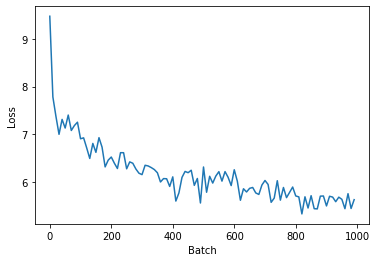

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0,1000,10),losses[1:])
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()